In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported autom)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config

In [2]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)

In [3]:
eth_client.get_eth_last_price()

{'ethbtc': '0.07518',
 'ethbtc_timestamp': '1651828328',
 'ethusd': '2722.33',
 'ethusd_timestamp': '1651828328'}

# Nexus Tokenomics Investigation

## Current Bonding Curve Set-up & Parameters

In [5]:
nxm_supply = 6_882_586
act_cover = 140_192
capital_factor = 4.8
mcr_floor = 162_425
mcr = max(mcr_floor, act_cover/capital_factor)
cap_pool = 155_503
mcrp = cap_pool/mcr
book_value = cap_pool/nxm_supply
print(f'mcrp: {mcrp}, book value: {book_value}')

mcrp: 0.9573834077266431, book value: 0.02259368789579963


In [6]:
a = 0.01028
c = 5_800_000
token_price = a + (mcr/c)*(mcrp**4)
token_price

0.03380710376606992

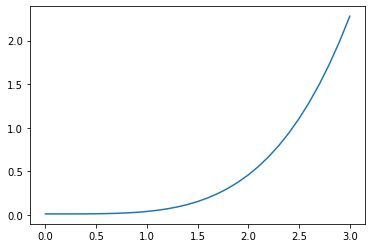

In [7]:
perc_range = np.linspace(0, 3, 31)

token_price_range = a + (mcr/c)*(perc_range**4)
plt.plot(perc_range, token_price_range);

## New Version - Capital Entry

### Current wNXM price feed

In [8]:
url = 'https://api.coingecko.com/api/v3/simple/price'
params = {
        'ids':'wrapped-nxm',
        'vs_currencies': 'eth'
        }
current_wnxm_price_eth = requests.get(url, params=params).json()['wrapped-nxm']['eth']
current_wnxm_price_eth

0.01038648

### Bond Discount Formula

In [9]:
perc_range_below_100 = np.linspace(0, 1, 21)
perc_range_below_100

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

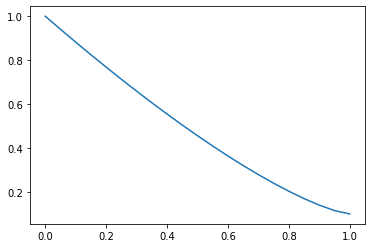

In [10]:
# creating shape of discount vs. mcr_perc below 100%
def mcr_perc_bond_discount(mcr_perc):
    return (1 - mcr_perc)**1.3 + mcr_perc*0.1

mcr_discount_range = mcr_perc_bond_discount(perc_range_below_100)

plt.plot(perc_range_below_100, mcr_discount_range);

In [11]:
for i in np.linspace(0, 0.99, 100):
    print(f'MCR% at {round(i, 2)}:\
          Monthly interest at {round(mcr_perc_bond_discount(i)*100, 2)}%,\
          Annual interest at {round(((1+mcr_perc_bond_discount(i))**12 - 1)*100, 2)}%')

MCR% at 0.0:          Monthly interest at 100.0%,          Annual interest at 409500.0%
MCR% at 0.01:          Monthly interest at 98.8%,          Annual interest at 381007.77%
MCR% at 0.02:          Monthly interest at 97.61%,          Annual interest at 354427.53%
MCR% at 0.03:          Monthly interest at 96.42%,          Annual interest at 329636.31%
MCR% at 0.04:          Monthly interest at 95.23%,          Annual interest at 306518.67%
MCR% at 0.05:          Monthly interest at 94.05%,          Annual interest at 284966.25%
MCR% at 0.06:          Monthly interest at 92.87%,          Annual interest at 264877.39%
MCR% at 0.07:          Monthly interest at 91.7%,          Annual interest at 246156.73%
MCR% at 0.08:          Monthly interest at 90.53%,          Annual interest at 228714.83%
MCR% at 0.09:          Monthly interest at 89.36%,          Annual interest at 212467.8%
MCR% at 0.1:          Monthly interest at 88.2%,          Annual interest at 197337.04%
MCR% at 0.11:    

In [12]:
def bond_discount(days, mcr_perc):
    # Instantaneous - you can buy NXM at the wNXM market price
    # Linearly 365 days to provide 15% discount (equivalent to APY of 15%)
    return (1 - min(1, mcr_perc))**1.3

In [14]:
bond_discount(365, mcrp)

0.016536832800110087

## New Version - Capital Exit

### Weighted average days on covers 

In [35]:
### TODO: Provide live feed instead of just pulling in .csv
# https://github.com/rchen8/nexus-mutual-tracker

In [15]:
# bring in csv
active_covers_expiration = pd.read_csv('../raw_data/active_cover_amount_by_expiration_date.csv')
# rename columns
active_covers_expiration.columns = ['exp_time', 'USD', 'ETH']
# convert expiry time from string to datetime
active_covers_expiration['exp_time'] = pd.to_datetime(active_covers_expiration['exp_time'])
# create a 'days remaining column by subtracting today's date in datetime format
active_covers_expiration['days_remaining'] = active_covers_expiration['exp_time']-pd.Timestamp.now().normalize()
# create an integer minutes remaining column by dividing by a timedelta minute object
active_covers_expiration['minutes_remaining'] = active_covers_expiration['days_remaining']/np.timedelta64(1, 'm')

#calculate weighted average minutes remaining based on cover amount
wavg_minutes = ((active_covers_expiration['ETH']*active_covers_expiration['minutes_remaining'])
                /active_covers_expiration['ETH'].sum()).sum()

# calculate 
wavg_days = wavg_minutes/(24*60)
wavg_days

63.34934315911215

### Calculating Exit Penalty

In [26]:
## currently linear up to weighted average

# TODO: this needs an amplification factor to allow for a margin - we don't want to just base it on weighted average days
# TODO: we are also not going to make it perfectly linear - earlier exit should be punished more
def exit_penalty(days_selected):
    amp_factor = 1.5
    amp_days = amp_factor * wavg_days
    if mcrp > 100:
        return 1
    else:
        return 1 - min(1, days_selected/amp_days)**2

In [27]:
exit_penalty(30)

0.9003274064959748

### Dynamic Current Assets

DCA(X) = Size of capital pool X-days in the future, i.e. current Capital Pool minus all the 

Few options for possible values of X:
- X can be any number of days & is calculated as quotes for certain days come in (likely not possible due to gas)
- X can be some set values, like 30, 60, 90, 180, 365 and we use the closest
- X can be a single value - easiest from implementation and gas perspective, but this may result in selling policies with capital we don't have unless X = 365 

In [ ]:
def dca(x):
    

## Initial Reverse Dutch Auction Mechanism

At launch, exit price = wnxm price

Price slowly increases, but starts dropping down once people try to exit through the mechanism

Keeps going up, stops at book value.

Incentive not to wait longer - some people may end up exiting in front of you and drive down the price.
What if you believe it'll go up eventually anyway...

## Scenario testing

1. WNXM price movements & how the market reacts
2. Crowd exits quickly/slowly/doesn't want to exit at all
    - 5/10/20/50/80% instant withdrawals?